# Data Exploring

In [142]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import re
import string
import lightgbm as lgb
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import warnings
import nltk
from scipy import stats
from tqdm import tqdm
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords 
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train_df = pd.read_excel('Train-Data-Sample.xlsx')
test_df = pd.read_excel('Test-Data-Sample.xlsx')

print('shape : ',train_df.shape)
train_df.head(10)


shape :  (11094, 9)


,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes
5,ID_5221,"Rmz Centennial, I Gate, Whitefield","South Indian, North Indian, Chinese",₹150,₹50,3.8,46,18,30 minutes
6,ID_3777,Mumbai Central,"Beverages, Fast Food",₹150,₹50,3.7,108,31,30 minutes
7,ID_745,Delhi University-GTB Nagar,"Chinese, Thai, Asian",₹650,₹50,4.0,1731,1235,45 minutes
8,ID_2970,Delhi University-GTB Nagar,"Mithai, Street Food",₹100,₹50,3.9,110,26,30 minutes
9,ID_3474,"Sector 1, Noida","Fast Food, North Indian, Rolls, Chinese, Momos...",₹200,₹50,3.9,562,294,65 minutes


In [76]:
train_df.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Average_Cost', 'Minimum_Order',
       'Rating', 'Votes', 'Reviews', 'Delivery_Time'],
      dtype='object')

In [77]:
train_df.isnull().sum()

Restaurant       0
Location         0
Cuisines         0
Average_Cost     0
Minimum_Order    0
Rating           0
Votes            0
Reviews          0
Delivery_Time    0
dtype: int64

In [78]:
train_df.describe(include='all')

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
count,11094,11094,11094,11094,11094,11094,11094,11094,11094
unique,7480,35,2179,26,18,33,1103,761,7
top,ID_7184,"Mico Layout, Stage 2, BTM Layout,Bangalore",North Indian,₹200,₹50,-,-,-,30 minutes
freq,22,947,850,3241,10118,1191,2074,2312,7406


In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Restaurant     11094 non-null  object
 1   Location       11094 non-null  object
 2   Cuisines       11094 non-null  object
 3   Average_Cost   11094 non-null  object
 4   Minimum_Order  11094 non-null  object
 5   Rating         11094 non-null  object
 6   Votes          11094 non-null  object
 7   Reviews        11094 non-null  object
 8   Delivery_Time  11094 non-null  object
dtypes: object(9)
memory usage: 780.2+ KB


# NLP


In [80]:

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

#A function to find all the non numeric values
def non_numerals(series):
    non_numerals = []
    for i in series.unique():
        try :
            i = float(i)
        except:
            non_numerals.append(i)
    return non_numerals

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [81]:
non_numerals(train_df['Rating'])

['-', 'NEW', 'Opening Soon', 'Temporarily Closed']

In [82]:
non_numerals(test_df['Rating'])

['NEW', '-', 'Opening Soon']

In [83]:
non_numerals(train_df['Votes'])

['-']

In [84]:
non_numerals(test_df['Votes'])

['-']

In [85]:
non_numerals(train_df['Reviews'])

['-']

In [86]:
non_numerals(test_df['Reviews'])

['-']

In [87]:
# A function to replace the non-numeric values
def replace_nn_with(series, type_, fill_with = None, method = 'mean'):
    nn = non_numerals(series)
    print('-'*30)
    print('-'*30)
    print("Non Numerals in column ",series.name," : ",nn)
    series = series.replace(nn, np.nan, inplace = False)
    nulls = series.isnull().sum()
    if fill_with:
        series.fillna(fill_with, inplace = True)
        print("Filling Non Numerals with {}".format(fill_with))
    else:
        series = series.replace(nn, np.nan, inplace = False)

    if method == 'mean' :
        rep = series.astype(float).mean()
        print("Filling Non Numerals with MEAN = ", rep)

    elif method =='median' :
        rep = series.astype(float).median()
        print("Filling Non Numerals with MEDIAN = ", rep)

    elif method =='min' :
        rep = series.astype(float).min()
        print("Filling Non Numerals with MINIMUM = ", rep)
    else:
        print('Please pass a valid method as a string -- ("mean" or "median" or "min")')
    return 0

    series.fillna(rep, inplace = True)
    try:
        series = series.astype(type_)
        print(nulls, ": observations replaced")
        return series
    except:
        series =  series.astype(float)
        print(nulls, ": observations replaced")
        series =  series.astype(type_)
    return series

In [88]:
replace_nn_with(train_df['Rating'], float, fill_with = 3.611078, method = 'mean')

------------------------------
------------------------------
Non Numerals in column  Rating  :  ['-', 'NEW', 'Opening Soon', 'Temporarily Closed']
Filling Non Numerals with 3.611078
Filling Non Numerals with MEAN =  3.6130382291330485


0

In [89]:
replace_nn_with(train_df['Votes'], float, fill_with = '244', method = 'mean')

------------------------------
------------------------------
Non Numerals in column  Votes  :  ['-']
Filling Non Numerals with 244
Filling Non Numerals with MEAN =  244.44267171444025


0

In [90]:
replace_nn_with(train_df['Reviews'], float, fill_with = 123, method = 'mean')

------------------------------
------------------------------
Non Numerals in column  Reviews  :  ['-']
Filling Non Numerals with 123
Filling Non Numerals with MEAN =  123.19623219758428


0

In [91]:
train_df['Rating'] = train_df['Rating'].apply(lambda x: x.replace('-', '3.6'))
train_df['Rating'] = train_df['Rating'].apply(lambda x: x.replace('NEW', '3.6'))
train_df['Rating'] = train_df['Rating'].apply(lambda x: x.replace('Opening Soon', '3.6'))
train_df['Rating'] = train_df['Rating'].apply(lambda x: x.replace('Temporarily Closed', '3.6'))

In [92]:
train_df['Votes'] = train_df['Votes'].apply(lambda x: x.replace('-', '244'))
train_df['Reviews'] = train_df['Reviews'].apply(lambda x: x.replace('-', '123'))

In [93]:
replace_nn_with(test_df['Rating'], float, fill_with = None, method = 'mean')

------------------------------
------------------------------
Non Numerals in column  Rating  :  ['NEW', '-', 'Opening Soon']
Filling Non Numerals with MEAN =  3.600044111160123


0

In [94]:
replace_nn_with(test_df['Votes'], float, fill_with =None, method = 'mean')

------------------------------
------------------------------
Non Numerals in column  Votes  :  ['-']
Filling Non Numerals with MEAN =  226.92831541218638


0

In [95]:
replace_nn_with(test_df['Reviews'], float, fill_with =None, method = 'mean')

------------------------------
------------------------------
Non Numerals in column  Reviews  :  ['-']
Filling Non Numerals with MEAN =  111.41082072443834


0

In [96]:
test_df['Rating'] = test_df['Rating'].apply(lambda x: x.replace('-', '3.6'))
test_df['Rating'] = test_df['Rating'].apply(lambda x: x.replace('NEW', '3.6'))
test_df['Rating'] = test_df['Rating'].apply(lambda x: x.replace('Opening Soon', '3.6'))

In [97]:
test_df['Votes'] = test_df['Votes'].apply(lambda x: x.replace('-', '226'))
test_df['Reviews'] = test_df['Reviews'].apply(lambda x: x.replace('-', '111'))

In [98]:
train_df.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12,4,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11,4,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99,30,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176,95,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521,235,65 minutes


In [99]:
train_df['Average_Cost'] = train_df['Average_Cost'].apply(lambda x: x.replace('₹', ''))
test_df['Average_Cost'] = test_df['Average_Cost'].apply(lambda x: x.replace('₹', ''))

In [100]:
import re

trim_function = lambda x : re.findall("^\s*(.*?)\s*$",str(x))[0]

remove_commas = lambda x: re.sub("[^\d]", "", str(x))


train_df['Average_Cost']= train_df['Average_Cost'].apply(trim_function).apply(remove_commas)

In [101]:
train_df['Average_Cost']=train_df['Average_Cost'].replace(r'^\s*$', np.nan, regex=True)

In [102]:
train_df['Average_Cost']= train_df['Average_Cost'].fillna(train_df['Average_Cost'].value_counts().idxmax())

In [103]:
train_df['Average_Cost']= train_df['Average_Cost'].astype(int)

In [104]:
test_df['Average_Cost']= test_df['Average_Cost'].apply(trim_function).apply(remove_commas).astype(int)

In [105]:
train_df['Minimum_Order'] = train_df['Minimum_Order'].apply(lambda x: x.replace('₹', ''))
test_df['Minimum_Order'] = test_df['Minimum_Order'].apply(lambda x: x.replace('₹', ''))

In [106]:
import re

trim_function = lambda x : re.findall("^\s*(.*?)\s*$",str(x))[0]

remove_commas = lambda x: re.sub("[^\d]", "", str(x))


train_df['Minimum_Order']= train_df['Minimum_Order'].apply(trim_function).apply(remove_commas).astype(int)
test_df['Minimum_Order']= test_df['Minimum_Order'].apply(trim_function).apply(remove_commas).astype(int)

In [107]:
train_df['Rating']= train_df['Rating'].astype(float)
train_df['Votes']= train_df['Votes'].astype(float)
train_df['Reviews']= train_df['Reviews'].astype(float)

In [108]:
test_df['Rating']= test_df['Rating'].astype(float)
test_df['Votes']= test_df['Votes'].astype(float)
test_df['Reviews']= test_df['Reviews'].astype(float)

In [109]:
#Number of words in Location
train_df["sync_num_words"]=train_df['Location'].apply(lambda x :len(str(x).split()))
test_df["sync_num_words"]=test_df['Location'].apply(lambda x :len(str(x).split()))

#Number of unique words in Location
train_df["Syn_num_unique_words"] = train_df['Location'].apply(lambda x: len(set(str(x).split())))
test_df["Syn_num_unique_words"] = test_df['Location'].apply(lambda x: len(set(str(x).split())))

#Number of characters in Location

train_df["Syn_num_chars"] = train_df['Location'].apply(lambda x: len(str(x)))
test_df["Syn_num_chars"] = test_df['Location'].apply(lambda x: len(str(x)))

## Number of stopwords in the Location ##
train_df["Syn_num_stopwords"] = train_df['Location'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["Syn_num_stopwords"] = test_df['Location'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the Location ##
train_df["Syn_num_punctuations"] =train_df['Location'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["Syn_num_punctuations"] =test_df['Location'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the Location ##
train_df["Syn_num_words_upper"] = train_df['Location'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["Syn_num_words_upper"] = test_df['Location'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the Location ##
train_df["Syn_num_words_title"] = train_df['Location'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["Syn_num_words_title"] = test_df['Location'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the Location ##
train_df["mean_word_len"] = train_df['Location'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df['Location'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [110]:
def clean_text(text):
    text=text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    text = re.sub(r'www.[^ ]+', '', text)
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

train_df['Location'] = train_df['Location'].apply(clean_text)
test_df['Location'] = test_df['Location'].apply(clean_text)

In [111]:
def clean_text(text):
    text=text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    text = re.sub(r'www.[^ ]+', '', text)
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

train_df['Cuisines'] = train_df['Cuisines'].apply(clean_text)
test_df['Cuisines'] = test_df['Cuisines'].apply(clean_text)

In [112]:
## Number of words in the Cuisines ##
train_df["Cuisines_num_words"] = train_df["Cuisines"].apply(lambda x: len(str(x).split()))
test_df["Cuisines_num_words"] = test_df["Cuisines"].apply(lambda x: len(str(x).split()))

## Number of unique words in the Title ##
train_df["Cuisines_num_unique_words"] = train_df["Cuisines"].apply(lambda x: len(set(str(x).split())))
test_df["Cuisines_num_unique_words"] = test_df["Cuisines"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the Title ##
train_df["Cuisines_num_chars"] = train_df["Cuisines"].apply(lambda x: len(str(x)))
test_df["Cuisines_num_chars"] = test_df["Cuisines"].apply(lambda x: len(str(x)))

## Number of stopwords in the Title ##
train_df["Cuisines_num_stopwords"] = train_df["Cuisines"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df["Cuisines_num_stopwords"] = test_df["Cuisines"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the Title ##
train_df["Cuisines_num_punctuations"] =train_df['Cuisines'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["Cuisines_num_punctuations"] =test_df['Cuisines'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the Title ##
train_df["Cuisines_num_words_upper"] = train_df["Cuisines"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["Cuisines_num_words_upper"] = test_df["Cuisines"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the Title ##
train_df["Cuisines_num_words_title"] = train_df["Cuisines"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["Cuisines_num_words_title"] = test_df["Cuisines"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the Title ##
train_df["mean_word_len_Cuisines"] = train_df["Cuisines"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len_Cuisines"] = test_df["Cuisines"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [113]:
train_df.head(10)

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,sync_num_words,Syn_num_unique_words,Syn_num_chars,Syn_num_stopwords,Syn_num_punctuations,Syn_num_words_upper,Syn_num_words_title,mean_word_len,Cuisines_num_words,Cuisines_num_unique_words,Cuisines_num_chars,Cuisines_num_stopwords,Cuisines_num_punctuations,Cuisines_num_words_upper,Cuisines_num_words_title,mean_word_len_Cuisines
0,ID_6321,fti college law college road pune,fast food rolls burger salad wraps,200,50,3.5,12.0,4.0,30 minutes,6,6,35,0,2,1,5,5.000000,6,6,34,0,0,0,0,4.833333
1,ID_2882,sector marathalli,ice cream desserts,100,50,3.5,11.0,4.0,30 minutes,3,3,20,0,1,0,2,6.000000,3,3,18,0,0,0,0,5.333333
2,ID_1595,mumbai central,italian street food fast food,150,50,3.6,99.0,30.0,65 minutes,2,2,14,0,0,0,2,6.500000,5,4,29,0,0,0,0,5.000000
3,ID_5929,sector noida,mughlai north indian chinese,250,99,3.7,176.0,95.0,30 minutes,3,3,15,0,1,0,2,4.333333,4,4,28,0,0,0,0,6.250000
4,ID_6123,rmz centennial gate whitefield,cafe beverages,200,99,3.2,521.0,235.0,65 minutes,5,5,34,1,2,1,5,6.000000,2,2,14,0,0,0,0,6.500000
5,ID_5221,rmz centennial gate whitefield,south indian north indian chinese,150,50,3.8,46.0,18.0,30 minutes,5,5,34,1,2,1,5,6.000000,5,4,33,0,0,0,0,5.800000
6,ID_3777,mumbai central,beverages fast food,150,50,3.7,108.0,31.0,30 minutes,2,2,14,0,0,0,2,6.500000,3,3,19,0,0,0,0,5.666667
7,ID_745,delhi university gtb nagar,chinese thai asian,650,50,4.0,1731.0,1235.0,45 minutes,3,3,26,0,1,0,2,8.000000,3,3,18,0,0,0,0,5.333333
8,ID_2970,delhi university gtb nagar,mithai street food,100,50,3.9,110.0,26.0,30 minutes,3,3,26,0,1,0,2,8.000000,3,3,18,0,0,0,0,5.333333
9,ID_3474,sector noida,fast food north indian rolls chinese momos mug...,200,50,3.9,562.0,294.0,65 minutes,3,3,15,0,1,0,2,4.333333,8,8,50,0,0,0,0,5.375000


In [114]:
test_df.head(10)

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,sync_num_words,Syn_num_unique_words,Syn_num_chars,Syn_num_stopwords,Syn_num_punctuations,Syn_num_words_upper,Syn_num_words_title,mean_word_len,Cuisines_num_words,Cuisines_num_unique_words,Cuisines_num_chars,Cuisines_num_stopwords,Cuisines_num_punctuations,Cuisines_num_words_upper,Cuisines_num_words_title,mean_word_len_Cuisines
0,ID_2842,mico layout stage btm layout bangalore,north indian chinese assamese,350,50,4.2,361.0,225.0,6,6,42,0,3,1,4,6.166667,4,4,29,0,0,0,0,6.500
1,ID_730,mico layout stage btm layout bangalore,biryani kebab,100,50,3.6,226.0,111.0,6,6,42,0,3,1,4,6.166667,2,2,13,0,0,0,0,6.000
2,ID_4620,sector noida,fast food,100,50,3.6,36.0,16.0,3,3,15,0,1,0,2,4.333333,2,2,9,0,0,0,0,4.000
3,ID_5470,babarpur new delhi delhi,mithai north indian chinese fast food south in...,200,50,3.6,66.0,33.0,4,4,26,0,2,0,4,5.750000,8,7,50,0,0,0,0,5.375
4,ID_3249,sector noida,chinese fast food,150,50,2.9,38.0,14.0,3,3,15,0,1,0,2,4.333333,3,3,17,0,0,0,0,5.000
5,ID_506,yerawada pune maharashtra,north indian chinese,100,50,3.4,16.0,11.0,3,3,27,0,2,0,3,8.333333,3,3,20,0,0,0,0,6.000
6,ID_8321,raja bazar kolkata,south indian fast food,200,50,3.3,72.0,10.0,3,3,19,0,1,0,3,5.666667,4,4,22,0,0,0,0,4.750
7,ID_4559,sector marathalli,kerala south indian chinese,150,50,3.8,46.0,29.0,3,3,20,0,1,0,2,6.000000,4,4,27,0,0,0,0,6.000
8,ID_7982,sector noida,north indian,200,50,3.6,226.0,111.0,3,3,15,0,1,0,2,4.333333,2,2,12,0,0,0,0,5.500
9,ID_2869,block sector noida,mithai,200,50,3.2,5.0,2.0,4,4,25,0,3,0,3,5.500000,1,1,6,0,0,0,0,6.000


# Data Preprocessing


In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1, 1), lowercase=False)
train_route = tf.fit_transform(train_df['Cuisines'])
test_route = tf.transform(test_df['Cuisines'])

In [116]:
train_route = pd.DataFrame(data=train_route.toarray(), columns=tf.get_feature_names())

In [117]:
test_route = pd.DataFrame(data=test_route.toarray(), columns=tf.get_feature_names())

In [118]:
train_route.head()

,afghan,african,american,andhra,arabian,asian,assamese,awadhi,bakery,bangladeshi,bar,bbq,belgian,bengali,beverages,bihari,biryani,bohri,brazilian,bubble,burger,burmese,cafe,cantonese,charcoal,chettinad,chicken,chinese,coffee,continental,cream,desserts,dogs,eastern,european,fast,finger,food,french,frozen,german,goan,greek,gujarati,healthy,hot,hyderabadi,ice,indian,indonesian,...,konkan,korean,lankan,lebanese,lucknowi,maharashtrian,malaysian,malwani,mangalorean,meats,mediterranean,mex,mexican,middle,mishti,mithai,modern,momos,mughlai,naga,nepalese,north,odia,paan,parsi,pizza,pok,portuguese,rajasthani,raw,roast,rolls,salad,sandwich,seafood,south,spanish,sri,steak,street,sushi,tamil,tea,tex,thai,tibetan,turkish,vietnamese,wraps,yogurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.439374,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.222518,0.0,0.197944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400383,0.473561,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577657,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.628052,0.459459,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.628052,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.321313,0.0,0.571656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.515554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.447136,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.35698,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727532,0.0,0.0,0.378592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591743,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.806127,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [119]:
train_df = pd.concat([train_df, train_route], axis=1) 
train_df.drop('Cuisines', axis=1, inplace=True)

test_df = pd.concat([test_df, test_route], axis=1) 
test_df.drop('Cuisines', axis=1, inplace=True)

In [120]:
train_df.head()

,Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,sync_num_words,Syn_num_unique_words,Syn_num_chars,Syn_num_stopwords,Syn_num_punctuations,Syn_num_words_upper,Syn_num_words_title,mean_word_len,Cuisines_num_words,Cuisines_num_unique_words,Cuisines_num_chars,Cuisines_num_stopwords,Cuisines_num_punctuations,Cuisines_num_words_upper,Cuisines_num_words_title,mean_word_len_Cuisines,afghan,african,american,andhra,arabian,asian,assamese,awadhi,bakery,bangladeshi,bar,bbq,belgian,bengali,beverages,bihari,biryani,bohri,brazilian,bubble,burger,burmese,cafe,cantonese,charcoal,chettinad,...,konkan,korean,lankan,lebanese,lucknowi,maharashtrian,malaysian,malwani,mangalorean,meats,mediterranean,mex,mexican,middle,mishti,mithai,modern,momos,mughlai,naga,nepalese,north,odia,paan,parsi,pizza,pok,portuguese,rajasthani,raw,roast,rolls,salad,sandwich,seafood,south,spanish,sri,steak,street,sushi,tamil,tea,tex,thai,tibetan,turkish,vietnamese,wraps,yogurt
0,ID_6321,fti college law college road pune,200,50,3.5,12.0,4.0,30 minutes,6,6,35,0,2,1,5,5.000000,6,6,34,0,0,0,0,4.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.439374,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400383,0.473561,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577657,0.0
1,ID_2882,sector marathalli,100,50,3.5,11.0,4.0,30 minutes,3,3,20,0,1,0,2,6.000000,3,3,18,0,0,0,0,5.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,ID_1595,mumbai central,150,50,3.6,99.0,30.0,65 minutes,2,2,14,0,0,0,2,6.500000,5,4,29,0,0,0,0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.515554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,ID_5929,sector noida,250,99,3.7,176.0,95.0,30 minutes,3,3,15,0,1,0,2,4.333333,4,4,28,0,0,0,0,6.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.727532,0.0,0.0,0.378592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,ID_6123,rmz centennial gate whitefield,200,99,3.2,521.0,235.0,65 minutes,5,5,34,1,2,1,5,6.000000,2,2,14,0,0,0,0,6.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591743,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.806127,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1, 1), lowercase=False)
train_route = tf.fit_transform(train_df['Location'])
test_route = tf.transform(test_df['Location'])

In [122]:
train_route = pd.DataFrame(data=train_route.toarray(), columns=tf.get_feature_names())

In [123]:
test_route = pd.DataFrame(data=test_route.toarray(), columns=tf.get_feature_names())

In [124]:
train_route.head()

,administration,area,babarpur,bangalore,bazaar,bazar,begumpet,block,btm,cantt,centennial,central,chandni,chatta,chowk,city,college,colony,court,cst,delhi,dockyard,dumdum,electronic,flats,fti,gate,gora,gtb,gurgaon,gurgoan,high,hyderabad,india,industrial,jaya,kolkata,law,laxman,layout,maharashtra,majestic,malakpet,mangaldas,marathalli,mico,moulali,mumbai,musi,nagar,nathan,new,noida,noorkhan,north,panjetan,public,pune,raja,rajbari,rmz,road,saidabad,sandhurst,school,sector,stage,tejas,timarpur,tiretti,university,vihar,wadala,west,whitefield,yerawada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.758438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379219,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379219,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.263713,0.0,0.0,0.000000,0.260024,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.891413,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.453193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.794294,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.607534,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.765984,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.642860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518651,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.439322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.518651,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518651,0.0


In [125]:
train_df = pd.concat([train_df, train_route], axis=1) 
train_df.drop('Location', axis=1, inplace=True)

test_df = pd.concat([test_df, test_route], axis=1) 
test_df.drop('Location', axis=1, inplace=True)

In [126]:
train_df.head()

,Restaurant,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,sync_num_words,Syn_num_unique_words,Syn_num_chars,Syn_num_stopwords,Syn_num_punctuations,Syn_num_words_upper,Syn_num_words_title,mean_word_len,Cuisines_num_words,Cuisines_num_unique_words,Cuisines_num_chars,Cuisines_num_stopwords,Cuisines_num_punctuations,Cuisines_num_words_upper,Cuisines_num_words_title,mean_word_len_Cuisines,afghan,african,american,andhra,arabian,asian,assamese,awadhi,bakery,bangladeshi,bar,bbq,belgian,bengali,beverages,bihari,biryani,bohri,brazilian,bubble,burger,burmese,cafe,cantonese,charcoal,chettinad,chicken,...,gate,gora,gtb,gurgaon,gurgoan,high,hyderabad,india,industrial,jaya,kolkata,law,laxman,layout,maharashtra,majestic,malakpet,mangaldas,marathalli,mico,moulali,mumbai,musi,nagar,nathan,new,noida,noorkhan,north,panjetan,public,pune,raja,rajbari,rmz,road,saidabad,sandhurst,school,sector,stage,tejas,timarpur,tiretti,university,vihar,wadala,west,whitefield,yerawada
0,ID_6321,200,50,3.5,12.0,4.0,30 minutes,6,6,35,0,2,1,5,5.000000,6,6,34,0,0,0,0,4.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.439374,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379219,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.263713,0.0,0.0,0.000000,0.260024,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,ID_2882,100,50,3.5,11.0,4.0,30 minutes,3,3,20,0,1,0,2,6.000000,3,3,18,0,0,0,0,5.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.891413,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.453193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,ID_1595,150,50,3.6,99.0,30.0,65 minutes,2,2,14,0,0,0,2,6.500000,5,4,29,0,0,0,0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.607534,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,ID_5929,250,99,3.7,176.0,95.0,30 minutes,3,3,15,0,1,0,2,4.333333,4,4,28,0,0,0,0,6.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.765984,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.642860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,ID_6123,200,99,3.2,521.0,235.0,65 minutes,5,5,34,1,2,1,5,6.000000,2,2,14,0,0,0,0,6.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591743,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.806127,0.0,0.0,0.0,0.0,...,0.439322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.518651,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518651,0.0


In [127]:
train_df.drop('Restaurant', axis=1, inplace=True)
test_df.drop('Restaurant', axis=1, inplace=True)

In [128]:
duplicate_columns = test_df.columns[test_df.columns.duplicated()]

In [129]:
duplicate_columns_1 = train_df.columns[train_df.columns.duplicated()]

In [130]:

duplicate_columns_1

Index(['north'], dtype='object')

In [131]:
train_df.drop('north', axis=1, inplace=True)
test_df.drop('north', axis=1, inplace=True)

# Model Training and Testing

In [132]:
import random

train_df['Delivery_Time'] = train_df['Delivery_Time'].apply(lambda x: x.replace('minutes', ''))

#train_df['Delivery_Time'] = train_df['Delivery_Time'].apply(lambda x: random.randint(30, 60))

X = train_df.drop(labels=['Delivery_Time'], axis=1)
y = train_df['Delivery_Time'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


In [133]:
#X_test = test_df

In [134]:
X_train1 = X_train
X_test1 = X_test
y_train1 = y_train
y_test1 = y_test

In [135]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier

results = []
names = []
models = []
chart = []

models.append(('Neural Network', MLPClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Linear Regression', linear_model.LinearRegression()))
models.append(('K nearest neighbours', KNeighborsClassifier()))
models.append(('XGBoost', XGBClassifier()))

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    chart.append([name,cv_results.mean()])
    print(name, 'Accuracy :', cv_results.mean())

Neural Network Accuracy : 0.696514423076923
Decision Tree Classifier Accuracy : 0.7046875
Linear Regression Accuracy : 0.1429960866007523
K nearest neighbours Accuracy : 0.7034855769230769
XGBoost Accuracy : 0.7253605769230769


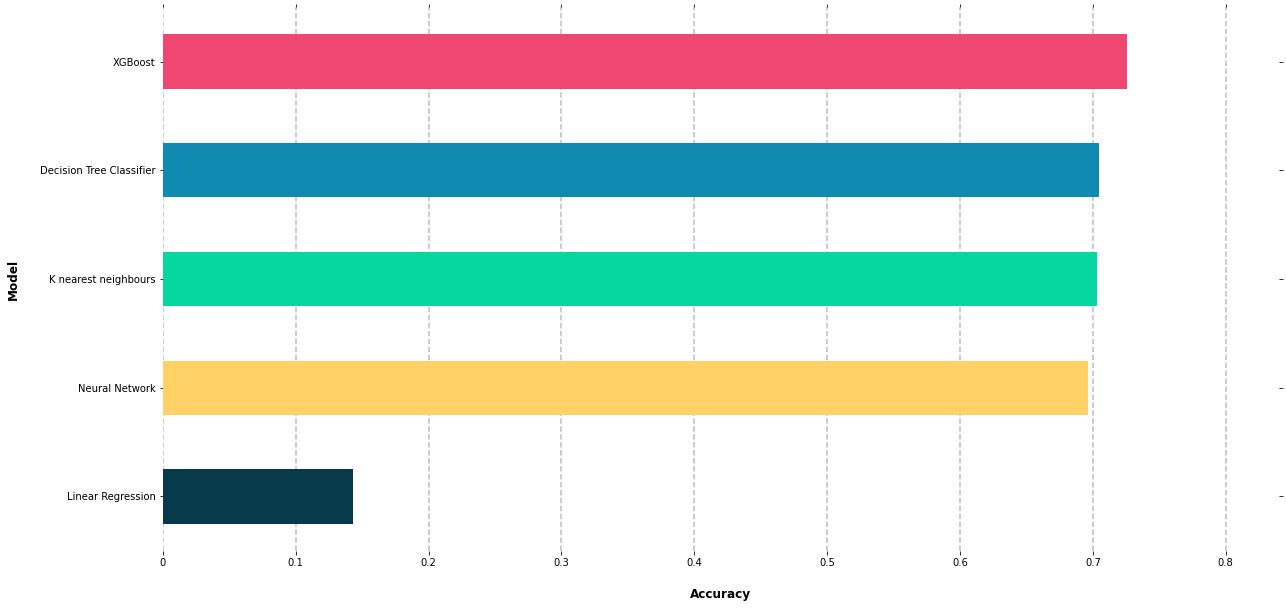

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

df = pd.DataFrame(chart, columns = ['Model', 'Accuracy'])
fig, ax = plt.subplots()
x = df.groupby('Model')['Accuracy'].mean().sort_values().tail(15)


ax.set_xlabel('Accuracy')


my_colors = 'rgbkymc' 

ax = x.plot(kind='barh', figsize=(20, 10), color=['#073b4c','#ffd166','#06d6a0','#118ab2','#ef476f'], zorder=2, width=0.5)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis = "both", which = "both", bottom = "off", top = "off", labelbottom = "on", left = "off", right = "off", labelleft = "on")

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x = tick, linestyle = 'dashed', alpha = 0.4, color = '#555b6e', zorder = 1)

# Set x - axis label
ax.set_xlabel("Accuracy", labelpad = 20, weight = 'bold', size = 12)

# Set y - axis label
ax.set_ylabel("Start Station", labelpad = 20, weight = 'bold', size = 12)

# Format y - axis label
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
x.plot(kind = 'barh')

In [137]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#Training the classifier

xgb.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [138]:
#Predicting for test set
from sklearn import metrics

y_predictions = xgb.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predictions)))



Mean Absolute Error: 5.708363374188897
Root Mean Squared Error: 11.85141426950619


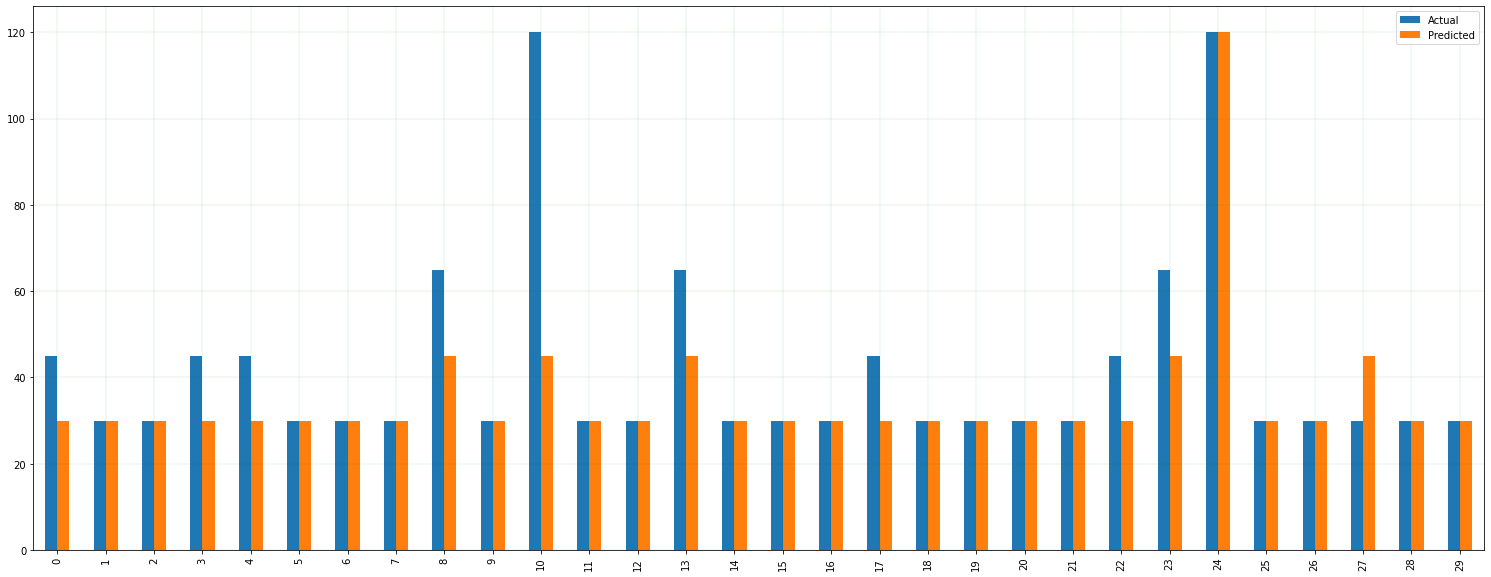

In [139]:
df1 = pd.DataFrame({'Actual': y_test1, 'Predicted': y_predictions}).head(30)
df1['Actual'] = df1['Actual'].astype(int)
df1['Predicted'] = df1['Predicted'].astype(int)

df1.plot(kind='bar',figsize=(26,10))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='green')
plt.show()